In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_data, load_config, write_to_file, one_hot_encoding

# Load configuration
config = load_config('./config.yaml')

# Load the data and reshape from (32 x 32) to (1024 x 1)
x_train, y_train, x_test, y_test = load_data()

In [2]:
# One-hot encoding
y_train = np.eye(len(y_train), 10)[y_train]
y_test = np.eye(len(y_test), 10)[y_test]

x_train = np.array([image.reshape((1024)) for image in x_train], dtype='float')
x_test = np.array([image.reshape((1024)) for image in x_test], dtype='float')

# Create validation set out of training data.
num = int(len(x_train) * 0.8)
[x_train, x_val]= np.split(x_train, [num])
[y_train, y_val] = np.split(y_train, [num])

In [3]:
# Calculate feature mean and standard deviation for x_train, and use them to
# Z score x_train, X_val and X_test
def z_score_train_test(train, val, test):
    train_T = train.T
    val_T = val.T
    test_T = test.T
    for i in range(len(train_T)):
        mean = np.mean(train_T[i])
        SD = np.std(train_T[i])
        train_T[i] = (train_T[i] - mean) / SD
        val_T[i] = (val_T[i] - mean) / SD
        test_T[i] = (test_T[i] - mean) / SD
    return train_T.T, val_T.T, test_T.T

# Z-scoring
x_train, x_val, x_test = z_score_train_test(x_train, x_val, x_test)

In [4]:
def accuracy(y, t):
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    res = [y_hat == t_hat for y_hat, t_hat in zip(y, t)]
    return np.sum(res) / len(res)

In [11]:
best_model = None
best_loss = float('inf')
curr_loss = float('inf')
prev_loss = float("inf")
train_acc = []
valid_acc = []
train_loss = []
valid_loss = []
patience = 5
patience_streak = 0

In [12]:
from neuralnet import *
from copy import deepcopy

model = NeuralNetwork(config=config)

In [13]:
# Stochastic gradient descent (SGD)
for i in range(config['epochs']):
    # Randomize the order of the indices into the training set
    shuffled_indices = np.random.permutation(len(x_train))
    x_train = x_train[shuffled_indices]
    y_train = y_train[shuffled_indices]
    for j in range(0, len(x_train), config['batch_size']):
        # Mini-batching
        if (j + config['batch_size'] < len(x_train)):
            batch_x = x_train[j : j + config['batch_size'], :]
            batch_y = y_train[j : j + config['batch_size'], :]
        else:
            batch_x = x_train[[j, len(x_train) - 1]]
            batch_y = y_train[[j, len(x_train) - 1]]
        
        model.forward(x=batch_x, targets=batch_y)
        model.backward()
        
    # Model performance evaluation
    y, curr_loss = model.forward(x=x_train, targets=y_train)
    train_loss.append(curr_loss)
    train_acc.append(accuracy(y, y_train))
    y, curr_loss = model.forward(x=x_val, targets=y_val)
    acc = accuracy(y, y_val)
    valid_loss.append(curr_loss)
    valid_acc.append(acc)
    # Best model
    if curr_loss < best_loss:
        best_loss = curr_loss
        best_model = deepcopy(model)
        print('[+] Epoch', i, 'Loss', curr_loss, 'Accuracy', acc)
    else:
        print('Epoch', i, 'Loss', curr_loss, 'Accuracy', acc)
    # Early stop
    if config['early_stop']:
        if i > config['early_stop_epoch']:
            if curr_loss >= best_loss:
                patience_streak += 1
            if patience_streak == 5:
                print('Early stopped at epoch', i)
                break
    prev_loss = curr_loss

[+] Epoch 0 Loss 1.5125646131920671 Accuracy 0.5013650013650014
[+] Epoch 1 Loss 1.1531823801810548 Accuracy 0.6517199017199017
[+] Epoch 2 Loss 1.0068472003623141 Accuracy 0.6998361998361998
[+] Epoch 3 Loss 0.9490036378821349 Accuracy 0.7083674583674584
[+] Epoch 4 Loss 0.8908662289617837 Accuracy 0.7262489762489762
[+] Epoch 5 Loss 0.8354428314145843 Accuracy 0.7422194922194922
[+] Epoch 6 Loss 0.8303858912727181 Accuracy 0.7442669942669943
[+] Epoch 7 Loss 0.7905391123448544 Accuracy 0.7563472563472563
[+] Epoch 8 Loss 0.7721807350226443 Accuracy 0.7614660114660114
[+] Epoch 9 Loss 0.7452302721256352 Accuracy 0.7719082719082719
[+] Epoch 10 Loss 0.7274197235953671 Accuracy 0.7801665301665301
Epoch 11 Loss 0.7323496518547108 Accuracy 0.7794840294840295
Epoch 12 Loss 0.7283954782252918 Accuracy 0.7757302757302758
[+] Epoch 13 Loss 0.7113756522611715 Accuracy 0.7818727818727819
[+] Epoch 14 Loss 0.7088549428290656 Accuracy 0.7862407862407862
[+] Epoch 15 Loss 0.708095668184403 Accurac

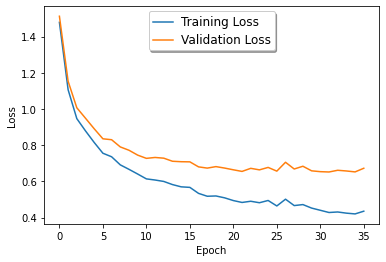

In [18]:
fig, axs = plt.subplots()
axs.plot(np.arange(0, len(train_loss)), train_loss, label='Training Loss')
axs.plot(np.arange(0, len(valid_loss)), valid_loss, label='Validation Loss')
legend = axs.legend(loc='upper center', shadow=True)
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel("Epoch", size=10.0)
plt.ylabel("Loss", size=10)
plt.show()

In [22]:
y, loss = model.forward(x=x_test, targets=y_test)
acc = accuracy(y, y_test)
acc

0.7698217578365089